In [7]:
import os
from os.path import join
import re
import collections
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.Seq import Seq

cwd = os.getcwd()
if cwd.endswith('notebook'):
    os.chdir('..')

In [8]:
sns.set(palette='colorblind', font_scale=1.3)
palette = sns.color_palette()

## Compare AA vs tri-nucleotide results

In [19]:
def load_global_bias_results(kind, query_type, tail='left'):
    if kind == 'tri-nucleotide':
        path = join(cwd, f'data/{query_type}_probability_{tail}.csv')
    else:
        path = join(cwd, f'data/{query_type}_aa_probability_{tail}.csv')
        
    df = pd.read_csv(path, index_col='id' if query_type == 'tigr' else 'query')
    df['rank'] = list(range(1, len(df) + 1))
    return df

In [20]:
pfam_tri = load_global_bias_results('tri-nucleotide', 'pfam')
tigr_tri = load_global_bias_results('tri-nucleotide', 'tigr')

pfam_aa = load_global_bias_results('amino-acid', 'pfam')
tigr_aa = load_global_bias_results('amino-acid', 'tigr')

In [21]:
def compute_difference_in_place(tri_df, aa_df):
    indices = set(tri_df.index.tolist()) & set(aa_df.index.tolist())
    tri_df_copy = tri_df.loc[indices].sort_values('rank').copy()
    tri_df_copy['rank'] = range(1, len(indices) + 1)
    for ix in indices:
        tri_rank = tri_df_copy.loc[ix]['rank']
        aa_rank = aa_df.loc[ix]['rank']
        aa_df.loc[ix, 'rank_tri'] = tri_rank
        aa_df.loc[ix, 'rank_aa'] = aa_rank
        aa_df.loc[ix, 'rank_diff'] = tri_rank - aa_rank
        aa_df.loc[ix, 'rank_diff_abs'] = np.abs(tri_rank - aa_rank)

In [22]:
compute_difference_in_place(pfam_tri, pfam_aa)
compute_difference_in_place(tigr_tri, tigr_aa)

In [24]:
trna_synt_tigr_id = tigr_aa[
    tigr_aa['description'].notnull() & 
    tigr_aa['description'].str.contains('--tRNA ligase')
].index
len(trna_synt_tigr_id)

35

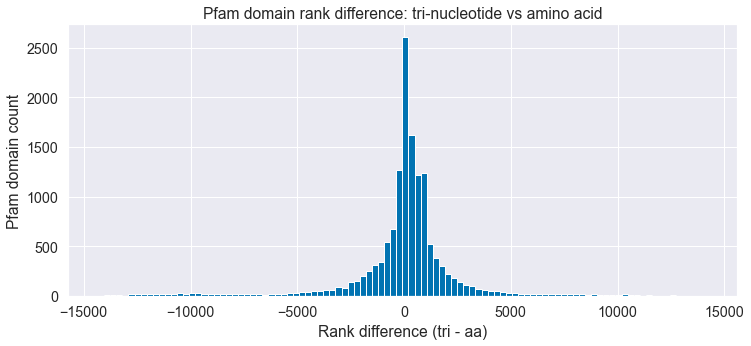

In [32]:
_, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.hist(pfam_aa[pfam_aa['rank_diff'].notnull()]['rank_diff'].values, bins=100);
ax.set_title('Pfam domain rank difference: tri-nucleotide vs amino acid');
ax.set_xlabel('Rank difference (tri - aa)');
ax.set_ylabel('Pfam domain count');

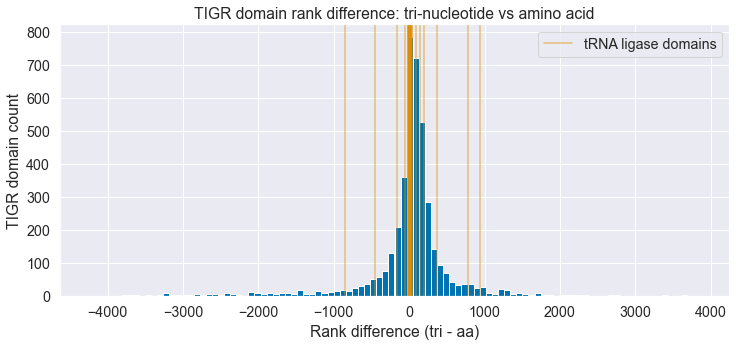

In [31]:
_, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.hist(tigr_aa[tigr_aa['rank_diff'].notnull()]['rank_diff'].values, bins=100);

for i, tigr_id in enumerate(trna_synt_tigr_id):
    label = 'tRNA ligase domains' if i == 0 else None
    ax.axvline(tigr_aa.loc[tigr_id]['rank_diff'], color=palette[1], alpha=0.5, label=label)

ax.set_title('TIGR domain rank difference: tri-nucleotide vs amino acid');
ax.set_xlabel('Rank difference (tri - aa)');
ax.set_ylabel('TIGR domain count');
ax.legend();

In [30]:
tigr_aa_out_df = tigr_aa.loc[trna_synt_tigr_id].sort_values('rank_diff_abs', ascending=True)[
    ['query', 'description', 'rank_tri', 'rank_aa', 'rank_diff']
].copy()
tigr_aa_out_df['rank_tri'] = tigr_aa_out_df['rank_tri'].astype(int)
tigr_aa_out_df['rank_aa'] = tigr_aa_out_df['rank_aa'].astype(int)
tigr_aa_out_df['rank_diff'] = tigr_aa_out_df['rank_diff'].astype(int)
tigr_aa_out_df.to_csv('/Users/srom/Downloads/tigr_aa_diff.csv');
tigr_aa_out_df

,query,description,rank_tri,rank_aa,rank_diff
id,,,,,
TIGR00398,metG,methionine--tRNA ligase,4,5,-1
TIGR00418,thrS,threonine--tRNA ligase,11,10,1
TIGR00396,leuS_bact,leucine--tRNA ligase,25,24,1
TIGR00442,hisS,histidine--tRNA ligase,19,17,2
TIGR00392,ileS,isoleucine--tRNA ligase,3,6,-3
TIGR00499,lysS_bact,lysine--tRNA ligase,28,31,-3
TIGR00344,alaS,alanine--tRNA ligase,7,3,4
TIGR00422,valS,valine--tRNA ligase,5,9,-4
TIGR00456,argS,arginine--tRNA ligase,10,4,6
